In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append(r"C:\Users\passenh\Documents\Harris\yr2_q1\ml\project\InterpretableDimRed")

In [3]:
import numpy as np 
import numpy.linalg as la
from InterpretableDimRed.utils import pca_svd_utils as psa
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
#Update the data directory to reflect your local machine
data_directory = "C:\\Users\\passenh\\Documents\\Harris\\yr2_q1\\ml\\project\\InterpretableDimRed\\InterpretableDimRed\\RawData\\"

# Building Interpretable Directions (Gu and Chipman)
Predict if patients will have heart disease or not based on 13 features.
For more info on this dataset see: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Chipman and Gu suggest taking the correlation between principle components and the original features, and applying a sort of thresholding algorithm to reset the coefficients in a way that may make them more interpretable. Among all the PC directions, for k = 1, 2, ... p, identify the k non-zero elements of the PC direction vector. Take the k elements with the largest absolute value, and set it equal to +1/-1 / sqrt(k); set all other elements equal to zero. Then find the vector with k elements which is "closest" to the original PC direction vector, and this is the "interpretable" direction. While Chipman and Gu measure angles between vectors, I am using the squared distance between the vectors as a measure of closeness.     

Their preprocessing includes removing categorical variables.

### Preprocessing

In [4]:
heart_data = pd.read_csv(data_directory + "heartDisease.csv")
heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
#remove categorical data
cont_vars = ["age", "trestbps", "chol", "thalach", "oldpeak"]

heart_data = heart_data[cont_vars + ["target"]]
heart_data.head()

,age,trestbps,chol,thalach,oldpeak,target
0,63,145,233,150,2.3,1
1,37,130,250,187,3.5,1
2,41,130,204,172,1.4,1
3,56,120,236,178,0.8,1
4,57,120,354,163,0.6,1


In [6]:
#normalize
heart_norm = psa.normalize(heart_data, cont_vars)
heart_norm.head()

,age,trestbps,chol,thalach,oldpeak,target
0,0.952197,0.763956,-0.256334,0.015443,1.087338,1
1,-1.915313,-0.092738,0.072199,1.633471,2.122573,1
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912,1
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705,1
4,0.290464,-0.663867,2.082050,0.583939,-0.379244,1


In [7]:
#separate the X and Y matrices
X = heart_norm.iloc[:,:-1]
Y = heart_norm.loc[:,"target"]

#set all the zeros to negative one
Y[Y == 0] = -1

C:\Users\passenh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Get principle components, and see correlations. 

In [8]:
pca = PCA(n_components=5, svd_solver='full')
pca.fit(X.T)

components = pca.components_

In [9]:
psa.corr_pc_features(X, components)

,PC1,PC2,PC3,PC4,PC5
age,-0.668345,0.318651,-0.361172,0.377165,0.01806
trestbps,-0.246095,-0.270005,-0.626999,-0.542521,0.01806
chol,-0.048788,0.757139,0.181113,-0.460957,0.01806
thalach,0.890973,-0.116014,-0.035809,0.111126,0.01806
oldpeak,-0.602736,-0.414141,0.515593,-0.142420,0.01806


In absolute magnitude terms the highest correlated variable is "thalach", which corresponds to the maximum heart rate of the patient, with age as the next most correlated variable, followed by oldpeak. 

### Run Chipman and Gu's algorithm 

Now, using Chipman and Gu's algorithm, we can try to find more "interpretable" directions for each principle component direction, and see the correlation between the intepretable directions and the original features.

In [10]:
#set up a matrix for the new interpretable directions
interp = np.zeros(components.shape)

for i, row in enumerate(components):
    pcrow = psa.c_and_g_algo(row)
    interp[i] = pcrow

In [11]:
psa.corr_pc_features(X, interp)

,PC1,PC2,PC3,PC4,PC5
age,-0.631758,0.286599,-0.325501,0.332937,-0.005173
trestbps,-0.236874,-0.251287,-0.565993,-0.455793,-0.006697
chol,-0.033860,0.636719,0.183764,-0.438569,0.079771
thalach,0.799845,-0.121023,-0.022245,0.129364,-0.009231
oldpeak,-0.559067,-0.365813,0.420799,-0.127505,0.121398


There is very little difference between the correlation of the interpretable direction and the original features - in the first "interpretable component" direction, the same variables have the highest correlation with the new interpretable directions. Age and oldpeak appear to be closer together, in absolute magnitude terms. 


### Use the most important principle components to make a classification prediction

Now, we can compare least squares classification, normal PCA, and Chipman and Gu's "interpretable directions" and examine performance. For consistency and valid comparisons, we we use least squares classification on the original features, the reduced dimension PCA and and reduced dimension Interpretable Directions.

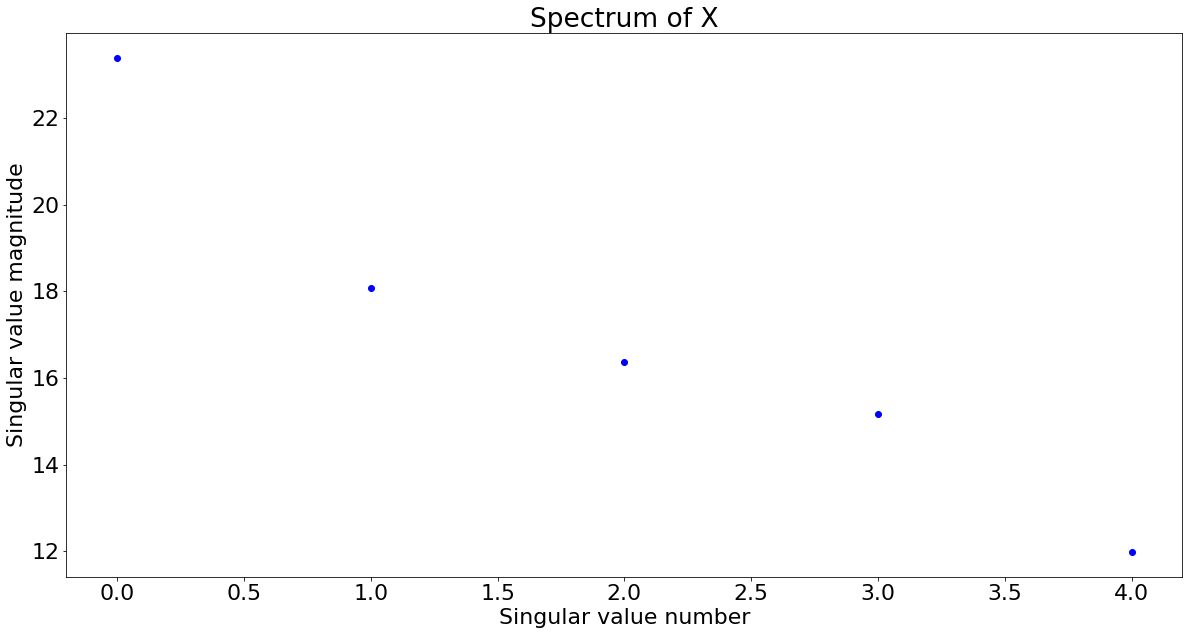

In [12]:
# Identify the most important principle components 
psa.plot_spectrum(X.T)

The first principle component looks like it has a greater difference from the next PC than all the others are from each other. I will therefore only consider the first principle component, and the corresponding interpretable component direction

In [13]:
#Get the first PCA direction and the first interpretable component direction
pca1 = components[0]
interp1 = interp[0]

pca1 = pca1.reshape(1, len(pca1))
interp1 = interp1.reshape(1, len(interp1))

In [14]:
X_train, X_test, y_train, y_test = psa.train_test_split_w(X, Y)
y_predicted = psa.least_squares_classifier(X_train.values, X_test.values, y_train.values)
print("""Accuracy score on the test set for a LS classifier using the original feature space is: {}""".format(accuracy_score(y_test.values, y_predicted)))

X_train_pca, X_test_pca, y_train_pca, y_test_pca = psa.train_test_split_w(pca1.T, Y)
y_predicted_pca = psa.least_squares_classifier(X_train_pca, X_test_pca, y_train_pca)
print("""Accuracy score on the test set for a LS classifier using principal component vector space is {}""".format(accuracy_score(y_test_pca.values, y_predicted_pca)))

X_train_interp, X_test_interp, y_train_interp, y_test_interp = psa.train_test_split_w(interp1.T, Y)
y_predicted_interp = psa.least_squares_classifier(X_train_interp, X_test_interp, y_train_interp.values)
print("""Accuracy score on the test set for a LS classifier using interpretable directions vector space is {}""".format(accuracy_score(y_test_interp.values, y_predicted_interp)))

Accuracy score on the test set for a LS classifier using the original feature space is: 0.7213114754098361
Accuracy score on the test set for a LS classifier using principal component vector space is 0.7049180327868853
Accuracy score on the test set for a LS classifier using interpretable directions vector space is 0.4098360655737705


The dimensionality-reduced Chipman and Gu "interpretable" directions results in significantly lower classification accuracy - the normal PCA dimensionality-reduced feature space performs much better than the more intepretable directions. 


## Repeat with another dataset

Predict if NBA rookies will last 5 or more years in the NBA based on player sats.

For more info on dataset visit: https://data.world/exercises/logistic-regression-exercise-1

### Step 1: Load and preprocess data

In [15]:
# Load and preprocess data
nba = pd.read_csv(data_directory + "nba_logreg.csv")
nba.head()  

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [16]:
#remove categorical data and normalize
nba = nba.loc[:, "GP":"TARGET_5Yrs"]
nba_cont = nba.columns[:-1]

#normalize
nba_norm = psa.normalize(nba, nba_cont)

#drop NA
nba_norm = nba_norm.dropna()
nba_norm.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,-1.400901,1.177066,0.137401,-0.017294,0.477347,-1.543407,0.658041,1.244354,0.355367,0.306333,0.361484,-0.037855,-0.398290,1.010852,0.517997,0.237640,-0.533458,0.073254,0.147338,0.0
1,-1.458281,1.116860,0.091486,-0.373816,0.226801,-2.374651,1.179494,1.903829,0.261716,1.319630,1.193248,0.586286,-0.655746,-0.018938,-0.308447,1.461613,1.175502,0.306415,0.562695,0.0
2,0.779563,-0.279912,-0.367659,-0.373816,-0.329969,-0.320991,0.397315,0.867511,0.317907,-0.402975,-0.394665,-0.312099,-0.655746,-0.239607,-0.405676,-0.374347,-0.289321,-0.159906,-0.268019,0.0
3,-0.138527,-0.725434,-0.252873,-0.195555,-0.107261,-0.255795,-0.384863,-0.263016,0.205525,-0.402975,-0.394665,-0.132422,-0.012104,-0.828059,-0.551519,-0.510344,-0.045184,-0.626228,-0.268019,1.0
4,-0.712333,-0.737475,-0.528360,-0.611497,-0.803224,1.341496,-0.645589,-0.639859,-1.205486,0.002344,0.059025,-0.274272,-0.012104,-0.386720,-0.259833,-0.850337,-0.777595,0.073254,-0.544923,1.0


In [17]:
#separate the X and Y matrices
nba_X = nba_norm.iloc[:,:-1]
nba_Y = nba_norm.loc[:, "TARGET_5Yrs"]

#set all the zeros to negative one
nba_Y[nba_Y == 0] = -1

### Step 2: Get principle components direction and see correlations

In [18]:
nba_pca = PCA(n_components=len(nba_cont), svd_solver='full')
nba_pca.fit(nba_X.T)

nba_components = nba_pca.components_

In [19]:
psa.corr_pc_features(nba_X, nba_components)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
GP,-0.236029,-0.343019,0.237616,-0.136524,-0.265339,0.676489,0.224289,0.130319,-0.049277,0.059889,-0.158643,0.005532,0.086379,0.114911,-0.087291,-0.131122,0.229281,-0.068767,-0.006498
MIN,-0.206750,-0.687284,-0.255304,0.010535,-0.068198,0.250106,0.011722,-0.157500,-0.193449,0.063170,-0.276159,-0.069609,0.300408,0.107211,-0.082473,-0.131551,0.228391,-0.068658,-0.006697
PTS,-0.246465,-0.724943,-0.248196,0.186795,0.147330,0.239152,0.099463,-0.033678,-0.218237,0.066556,-0.156979,-0.011156,0.073256,0.144713,-0.102589,-0.159885,0.244975,-0.076305,-0.006783
FGM,-0.288764,-0.708846,-0.226842,0.151880,0.141458,0.246813,0.114275,-0.077909,-0.311493,0.057099,-0.120655,-0.005971,0.052195,0.131797,-0.083008,-0.160242,0.214153,-0.062773,-0.006731
FGA,-0.153008,-0.763221,-0.278769,0.165700,0.076958,0.253153,0.098692,-0.070133,-0.298539,0.059366,-0.097583,-0.008859,0.056442,0.078110,-0.074756,-0.077049,0.232695,-0.069127,-0.006814
FG%,-0.635172,0.153599,0.253563,-0.183581,0.503066,0.128771,0.011396,-0.086237,-0.147797,0.028786,-0.212560,0.023541,0.116573,0.106399,-0.087867,-0.126220,0.231222,-0.069223,-0.006093
3P Made,0.655209,-0.190411,-0.488216,-0.042110,0.118767,0.306792,-0.114495,-0.017908,-0.017357,0.040421,-0.152510,0.019344,0.106962,0.196818,-0.072999,-0.112430,0.228125,-0.068237,-0.006839
3PA,0.669269,-0.245169,-0.491150,-0.030285,0.083193,0.287145,-0.129674,-0.017506,-0.015137,0.049009,-0.138386,0.016748,0.086423,0.033628,-0.100975,-0.151059,0.229467,-0.068732,-0.006884
3P%,0.649360,-0.031501,-0.201580,0.075329,-0.076790,-0.101251,0.569552,-0.051909,-0.144645,0.023698,-0.186182,0.008221,0.116061,0.114311,-0.087923,-0.131564,0.230081,-0.068967,-0.006554
FTM,-0.353590,-0.707066,-0.130173,0.320825,0.123890,0.094605,0.092172,0.123761,0.107836,0.082127,-0.223701,-0.038213,0.105263,0.122904,-0.143780,-0.114003,0.224949,-0.066973,-0.006831


At at glance, it appears that the number of offensive rebounds and total rebounds have the highest correlation in absolute magnitude, followed by blocks and 3 points made. 

### Run Chipman and Gu's algorithm to see the "interpretable" principle component directions. 

Again, using Chipman and Gu's algorithm, we can try to find more "interpretable" directions for each principle component direction, and see the correlation between the intepretable directions and the original features.

In [20]:
#set up a matrix for the new interpretable directions
nba_interp = np.zeros(nba_components.shape)

for i, row in enumerate(nba_components):
    pcrow = psa.c_and_g_algo(row)
    nba_interp[i] = pcrow

In [21]:
psa.corr_pc_features(nba_X, nba_interp)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
GP,-0.215894,-0.321136,0.210271,-0.117921,-0.234511,0.651689,0.242217,0.153270,-0.035338,0.068751,-0.145941,0.016437,0.121243,0.090105,-0.114466,-0.101524,0.208746,-0.033750,-0.025597
MIN,-0.147460,-0.587190,-0.246433,0.011990,-0.032139,0.247760,0.038423,-0.135459,-0.176537,0.053240,-0.263682,-0.066964,0.339475,0.086317,-0.081283,-0.112637,0.199889,-0.030389,-0.020067
PTS,-0.174928,-0.602951,-0.229447,0.161796,0.153812,0.229024,0.111130,-0.030472,-0.180210,0.059449,-0.142733,-0.016222,0.149636,0.117533,-0.083722,-0.111428,0.223177,-0.020778,-0.002434
FGM,-0.215482,-0.592882,-0.211430,0.133215,0.149776,0.234746,0.123387,-0.069586,-0.259235,0.050958,-0.112397,-0.011902,0.131242,0.108283,-0.074847,-0.108681,0.194597,-0.014738,-0.008360
FGA,-0.095988,-0.647738,-0.255609,0.149463,0.092765,0.232555,0.116271,-0.060754,-0.253724,0.051759,-0.089090,-0.010081,0.129988,0.060724,-0.064171,-0.055838,0.209207,-0.018026,-0.006579
FG%,-0.618781,0.194155,0.221094,-0.182651,0.442944,0.166137,-0.038163,-0.080123,-0.119587,0.036750,-0.227823,0.003187,0.125480,0.075259,-0.125500,-0.059185,0.201856,-0.032243,0.005864
3P Made,0.605911,-0.156435,-0.421563,-0.046311,0.131038,0.221911,-0.075904,-0.012754,-0.042466,0.043855,-0.152432,0.019440,0.095592,0.111647,-0.059770,-0.159845,0.212336,-0.052034,0.007612
3PA,0.623733,-0.204968,-0.419742,-0.034268,0.098373,0.205014,-0.082936,-0.009991,-0.040457,0.047519,-0.139351,0.018903,0.075187,-0.023808,-0.083740,-0.202768,0.211226,-0.050270,0.006045
3P%,0.651905,-0.016431,-0.174584,0.070303,-0.061727,-0.116107,0.492742,-0.034931,-0.140838,0.035594,-0.191833,0.021179,0.141842,0.098742,-0.062874,-0.162535,0.202512,-0.057997,-0.026274
FTM,-0.270157,-0.575893,-0.126939,0.276661,0.119151,0.123829,0.098244,0.108729,0.105976,0.070826,-0.189372,-0.040243,0.176254,0.115174,-0.091975,-0.056797,0.202672,-0.012758,0.012220


In this instance, some of the correlations have shifted. While offensive rebounds is still the most highly correlated, the 3 pointers made and three point percentage are more highly correlated - suggesting that this direction is the "offensive shots" direction. Indeed, some of the next most highly correlated features are three point attempts, field goal percent, and total rebounds. This direction, in which offensive behavior is all highly correlated, does appear to be more interpretable than the original PCA direction vector. 

### Use the most important principle components to make a classification prediction

Now, we can compare least squares classification, normal PCA, and Chipman and Gu's "interpretable directions" and examine performance. For consistency and valid comparisons, we we use least squares classification on the original features, the reduced dimension PCA and and reduced dimension Interpretable Directions.

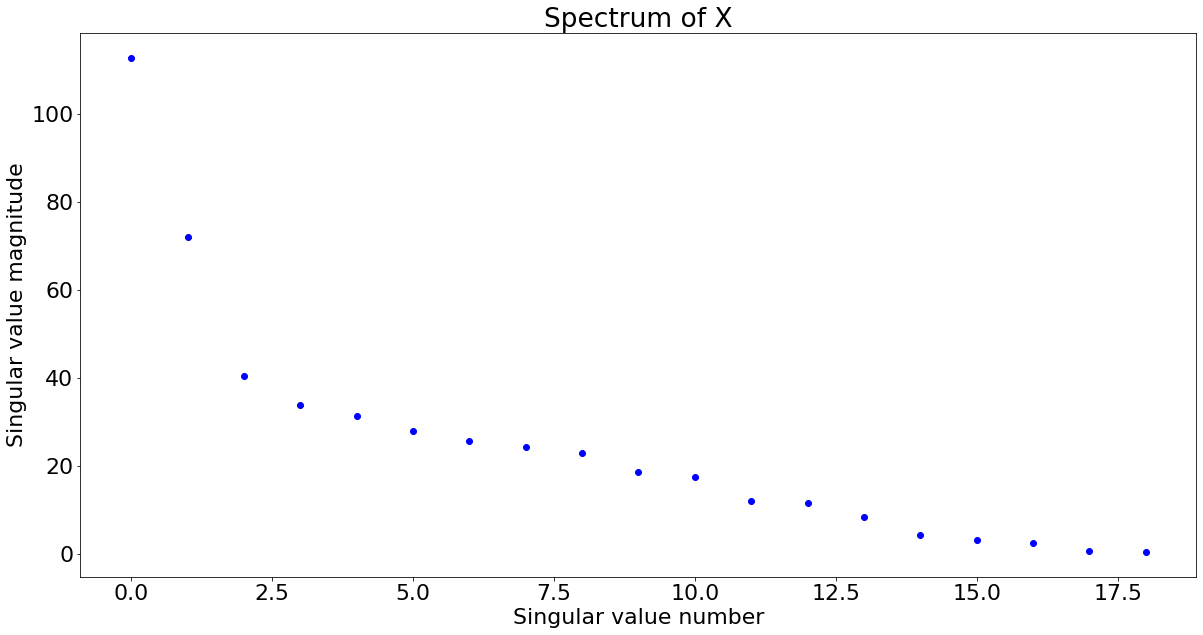

In [22]:
# Identify the most important principle components 
psa.plot_spectrum(nba_X.T)

The first two principle components appear to be largest, compared to the others - I will therefore reduce the data to 2 dimension both in the first two principle component directions, and in the "interpretable component" directions. 

In [28]:
#Get the first PCA direction and the first interpretable component direction
nba_pca2 = nba_components[:2]
nba_interp2 = nba_interp[:2]

In [27]:
nba_X_train, nba_X_test, nba_y_train, nba_y_test = psa.train_test_split_w(nba_X, nba_Y)
nba_y_predicted = psa.least_squares_classifier(nba_X_train.values, nba_X_test.values, nba_y_train.values)
print("""Accuracy score on the test set for a LS classifier using 
         the original feature space is: {}""".format(accuracy_score(nba_y_test.values, nba_y_predicted)))

nba_X_train_pca, nba_X_test_pca, nba_y_train_pca, nba_y_test_pca = psa.train_test_split_w(nba_pca2.T, nba_Y)
nba_y_predicted_pca = psa.least_squares_classifier(nba_X_train_pca, nba_X_test_pca, nba_y_train_pca)
print("""Accuracy score on the test set for a LS classifier using 
         principal component vector space is {}""".format(accuracy_score(nba_y_test_pca.values, nba_y_predicted_pca)))

nba_X_train_interp, nba_X_test_interp, nba_y_train_interp, nba_y_test_interp = psa.train_test_split_w(nba_interp2.T, nba_Y)
nba_y_predicted_interp = psa.least_squares_classifier(nba_X_train_interp, nba_X_test_interp, nba_y_train_interp.values)
print("""Accuracy score on the test set for a LS classifier using 
         interpretable directions vector space is {}""".format(accuracy_score(nba_y_test_interp.values, nba_y_predicted_interp)))

Accuracy score on the test set for a LS classifier using 
         the original feature space is: 0.6766917293233082
Accuracy score on the test set for a LS classifier using 
         principal component vector space is 0.5639097744360902
Accuracy score on the test set for a LS classifier using 
         interpretable directions vector space is 0.41729323308270677


In this case, the error when using the interpretable PCA direction is less of a large change from the regular PCA direction that it was with the heart disease data. One major difference between the datasets is the number of features - it's entirely possible that the larger number of features in this dataset make this method a better approximation. 